[*********************100%***********************]  1 of 1 completed


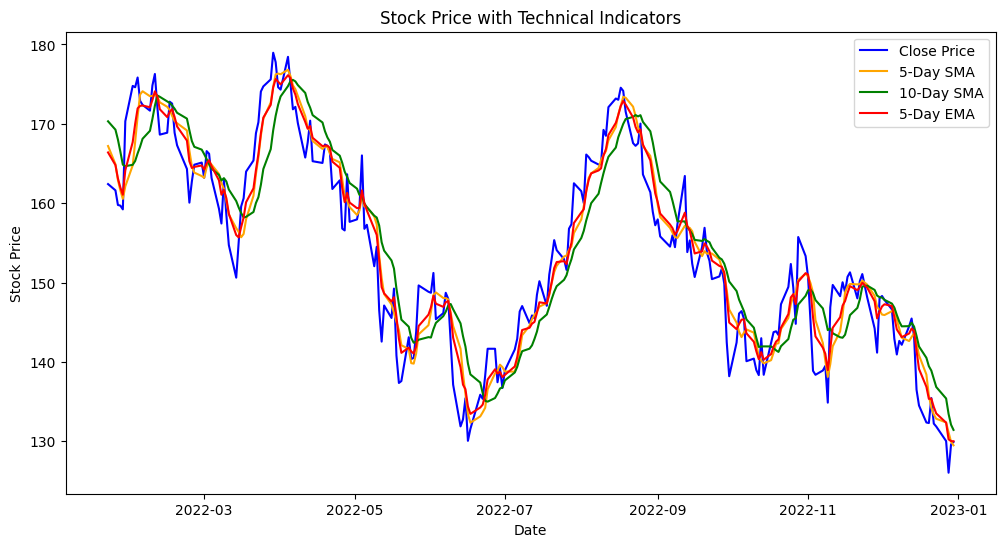

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - loss: 0.0969 - val_loss: 0.0166
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 0.0202 - val_loss: 0.0104
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0210 - val_loss: 0.0198
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0180 - val_loss: 0.0112
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0135 - val_loss: 0.0092
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0158 - val_loss: 0.0136
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.0145 - val_loss: 0.0108
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0103 - val_loss: 0.0099
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0093 - val_lo

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.layers import Bidirectional
import yfinance as yf

# Load real stock data using yfinance
def load_real_stock_data(stock_symbol="AAPL", start_date="2022-01-01", end_date="2023-01-01"):
    data = yf.download(stock_symbol, start=start_date, end=end_date)
    return data[['Close']]

# Load the stock data
stock_data = load_real_stock_data(stock_symbol="AAPL", start_date="2022-01-01", end_date="2023-01-01")

# Add technical indicators
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()  # 5-day moving average
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()  # 10-day moving average
stock_data['EMA_5'] = stock_data['Close'].ewm(span=5, adjust=False).mean()  # 5-day EMA
stock_data['RSI'] = 100 - (100 / (1 + (stock_data['Close'].diff(1).gt(0).rolling(window=14).sum() / 14)))  # 14-day RSI

# Drop any NaN values resulting from shifting or rolling
stock_data = stock_data.dropna()

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data['SMA_5'], label='5-Day SMA', color='orange')
plt.plot(stock_data['SMA_10'], label='10-Day SMA', color='green')
plt.plot(stock_data['EMA_5'], label='5-Day EMA', color='red')
plt.title('Stock Price with Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Prepare the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'SMA_5', 'SMA_10', 'EMA_5', 'RSI']])

# Prepare the sequences for LSTM input
lookback = 60  # Number of previous days to consider
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, :])  # Use multiple features
    y.append(scaled_data[i, 0])  # Target is the 'Close' price

X, y = np.array(X), np.array(y)

# Split the data into training and testing sets (80% for training, 20% for testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM model with Bidirectional LSTM layer
model = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Invert the scaling to get actual stock prices
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]



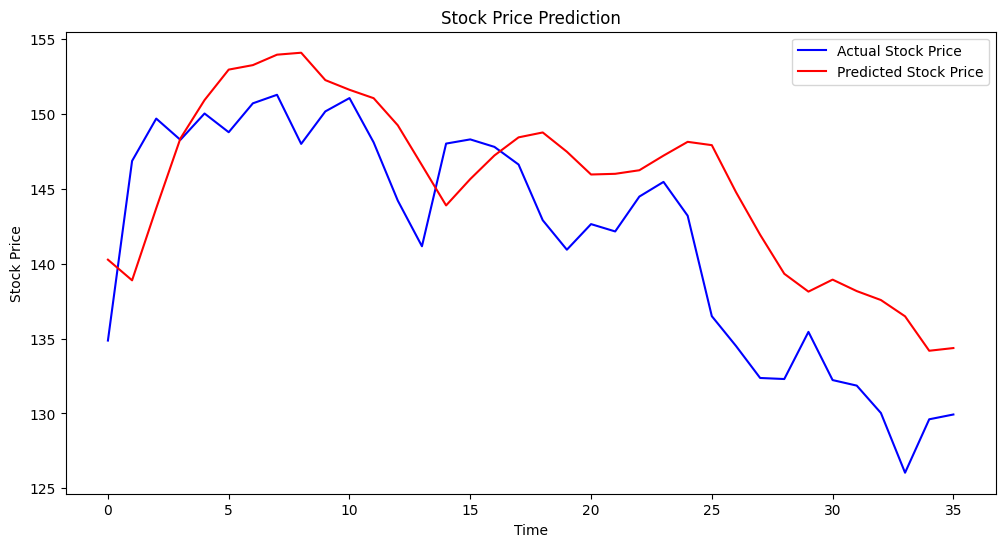

Mean Absolute Error (MAE): 4.726089230564036
Mean Squared Error (MSE): 30.646463255558483
Root Mean Squared Error (RMSE): 5.535924787744003
R-squared: 0.45888321633328144


In [7]:
# Plot the predictions vs actual prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared: {r2}')
